In [103]:
import math                
import torch               
import torch.nn as nn      
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os, random

***Homework #2***

# **First Function** 

The first function is defined as  

$$
f_{1}(x,y) = \sin(2\pi x) \cdot \sin(2\pi y)
$$

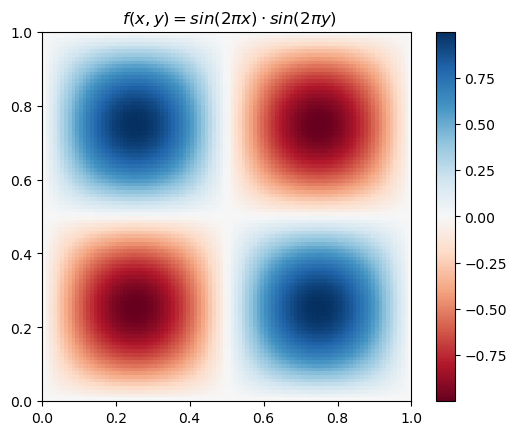

In [427]:
with torch.no_grad():
    p = torch.linspace(0,1,100)
    xp,yp = torch.meshgrid(p,p,indexing="ij")
    grid = torch.stack([xp.reshape(-1),yp.reshape(-1)], dim=1)
    Z_true = (torch.sin(2*math.pi*grid[:,0:1]) * torch.sin(2*math.pi*grid[:,1:2])).reshape(100,100)
plt.figure()
plt.title(r" $f(x,y) = sin(2\pi x) \cdot sin(2\pi y)$")
plt.imshow(Z_true.numpy(),extent=[0,1,0,1],cmap='RdBu')
plt.colorbar()
plt.savefig("F1-groundtruth.png", dpi=300, bbox_inches='tight')
plt.show()

*Seeding and Device Handling*

In [460]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED) 
# not strictly necessary, but setting this makes python's internal hash functions reproducible.  
# without it, things like the iteration order of dictionaries/sets can change between runs.  
# it helps ensure full reproducibility across different runs and environments.Will test work without it later.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);
# This is too much and unncessary rn, but in case I'm using a GPU to train my network in the future, it will help. Maybe one day
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

import os, torch
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

**Shallow Network**

epoch 500 | lr=0.01000 | train MSE=0.1821 | val MSE=0.1686
epoch 1000 | lr=0.01000 | train MSE=0.1433 | val MSE=0.1389
epoch 1500 | lr=0.01000 | train MSE=0.1339 | val MSE=0.1306
epoch 2000 | lr=0.01000 | train MSE=0.1250 | val MSE=0.1225
epoch 2500 | lr=0.01000 | train MSE=0.1163 | val MSE=0.1144
epoch 3000 | lr=0.01000 | train MSE=0.1074 | val MSE=0.1063
epoch 3500 | lr=0.01000 | train MSE=0.0975 | val MSE=0.0971
epoch 4000 | lr=0.01000 | train MSE=0.0855 | val MSE=0.0860
epoch 4500 | lr=0.01000 | train MSE=0.0719 | val MSE=0.0733
epoch 5000 | lr=0.01000 | train MSE=0.0593 | val MSE=0.0613
epoch 5500 | lr=0.01000 | train MSE=0.0497 | val MSE=0.0521
epoch 6000 | lr=0.01000 | train MSE=0.0431 | val MSE=0.0458
epoch 6500 | lr=0.01000 | train MSE=0.0384 | val MSE=0.0413
epoch 7000 | lr=0.01000 | train MSE=0.0347 | val MSE=0.0376
epoch 7500 | lr=0.01000 | train MSE=0.0315 | val MSE=0.0344
epoch 8000 | lr=0.01000 | train MSE=0.0287 | val MSE=0.0314
epoch 8500 | lr=0.01000 | train MSE=0.026

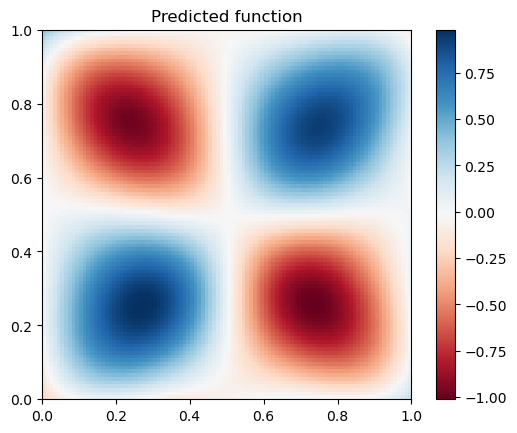

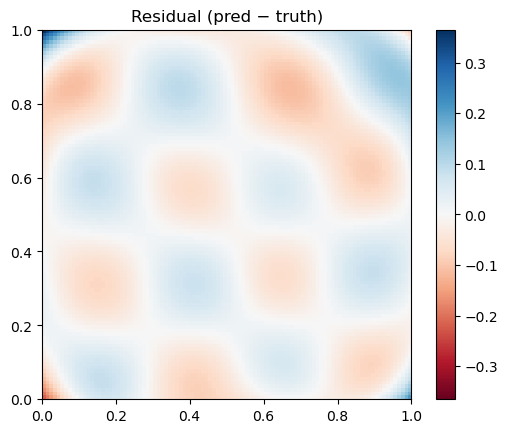

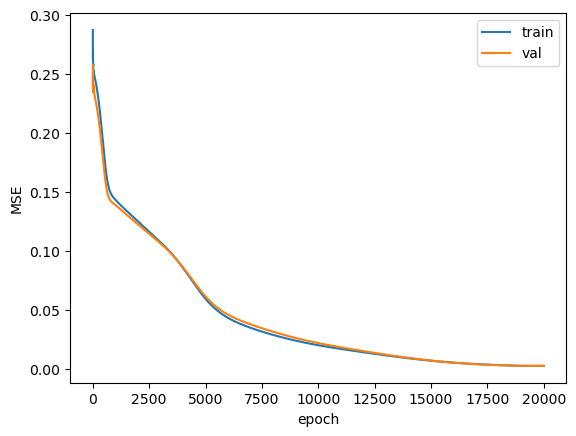

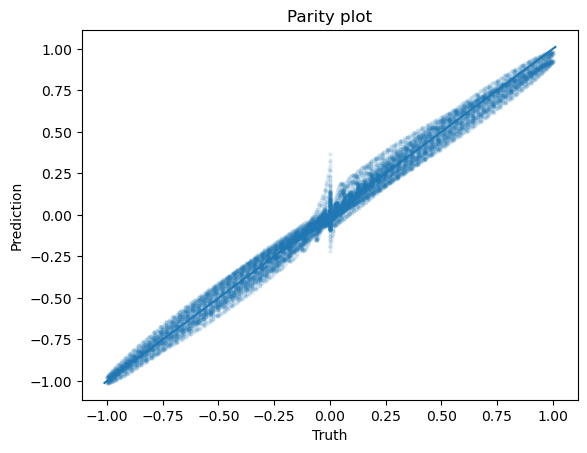

In [541]:
N = 4000
X = torch.rand(N,2) 
y = torch.sin(2*math.pi*X[:,0:1]) * torch.sin(2*math.pi*X[:,1:2])

# Training Split
n_train = int(0.8*N) # 80% of the data are used for training, and 20% for testing.
indices = torch.randperm(N,device=device) # this just shuffles the data; otherwise our training data will always be the first 80%
                                          # Also it avoids any potential bias if the data is structured.  
                                          # in this case, X is generated thru torch.rand which already produces i.i.d and not ordered so skipping the shuffle will not hurt.
train_idx, val_idx = indices[:n_train], indices[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

# Create the model
nodes = 30
act = nn.Tanh()
model = nn.Sequential(nn.Linear(2,nodes), act, nn.Linear(nodes,1)).to(device)

# Loss function and Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

best_val, best_epoch = float('inf'), -1
start_lr = optimizer.param_groups[0]['lr']
beta = optimizer.param_groups[0].get('momentum', 0.0)
# Training loop
epochs = 20000
train_hist, val_hist = [], []
best_val, best_epoch = float('inf'), -1
for epoch in range(epochs):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) == 19000:
        for g in optimizer.param_groups:
            g['lr'] = 0.001  
            
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, y_val)

    train_hist.append(loss.item())
    val_hist.append(val_loss.item())
    v = val_loss.item()
    if v < best_val:
        best_val, best_epoch = v, epoch+1
    if (epoch + 1) % 500 == 0:
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch+1} | lr={cur_lr:.5f} | train MSE={loss.item():.4f} | val MSE={v:.4f}")
final_train = train_hist[-1]
final_val   = val_hist[-1]
print("\n=== Summary ===")
print(f"optimizer=SGD, beta={beta:.2f}, lr0={start_lr}")
print(f"Best val MSE   : {best_val:.6f}")
print(f"Epoch of best  : {best_epoch}")
print(f"Final train MSE: {final_train:.6f}")
print(f"Final val MSE  : {final_val:.6f}")

p = torch.linspace(0, 1, 100, device=device)
xp, yp = torch.meshgrid(p, p, indexing="ij")
grid = torch.stack([xp.reshape(-1), yp.reshape(-1)], dim=1)

model.eval()
with torch.no_grad():
    Z_true = (torch.sin(2*math.pi*grid[:, 0:1]) * torch.sin(2*math.pi*grid[:, 1:2])).reshape(100, 100)
    Z_pred = model(grid).reshape(100, 100)

res = (Z_pred - Z_true).detach().cpu().numpy()
m = abs(res).max()
plt.figure(); plt.title("Predicted function")
plt.imshow(Z_pred.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="RdBu"); plt.colorbar()
plt.savefig("PredictedFunction.png", dpi=300, bbox_inches='tight')
#
plt.figure(); plt.title("Residual (pred − truth)")
plt.imshow(res, origin="lower", extent=[0,1,0,1], cmap="RdBu", vmin=-m, vmax=m); plt.colorbar()
plt.savefig("Residual.png", dpi=300, bbox_inches='tight')
plt.show()
#
plt.figure()
plt.plot(train_hist, label="train")
plt.plot(val_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend()
plt.savefig("MSEvsEpoch.png", dpi=300, bbox_inches='tight')
plt.show()
#
t = Z_true.detach().cpu().numpy().ravel()
p_ = Z_pred.detach().cpu().numpy().ravel()
m = max(abs(t).max(), abs(p_).max())
plt.figure(); plt.scatter(t, p_, s=5, alpha=0.1)
plt.plot([-m, m], [-m, m])
plt.xlabel("Truth"); plt.ylabel("Prediction"); plt.title("Parity plot"); 
plt.savefig("Parity.png", dpi=300, bbox_inches='tight')
plt.show()


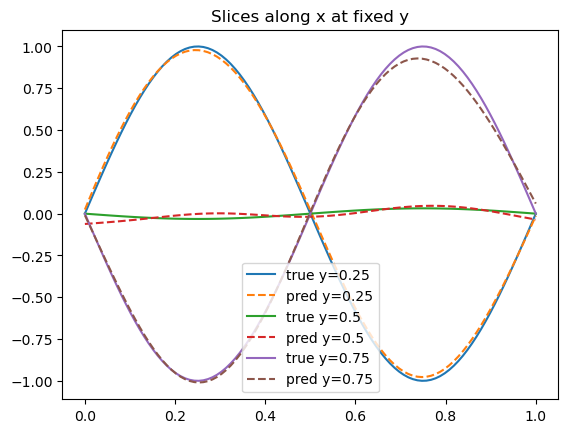

In [543]:
# assumes Z_* shape (100,100) with meshgrid(..., indexing="ij")
ys = [0.25, 0.50, 0.75]
for y0 in ys:
    j = int(round(y0*(100-1)))
    plt.plot(p.cpu().numpy(), Z_true[:, j].cpu().numpy(), label=f"true y={y0}")
    plt.plot(p.cpu().numpy(), Z_pred[:, j].detach().cpu().numpy(), "--", label=f"pred y={y0}")
plt.title("Slices along x at fixed y"); plt.legend(); plt.show()


In [305]:
m  = y.mean().item()                   # ~ 0.0
ms = (y**2).mean().item()              # ~ 0.25
var = y.var(unbiased=False).item()     # ~ 0.25 (population variance)
print(m, ms, m*m, var)

0.0024857844691723585 0.25394389033317566 6.179124427178504e-06 0.2539377212524414


In [307]:
print(y.mean().item())          # ~ 0.0
print((y**2).mean().item())     # ~ 0.25

0.0024857844691723585
0.25394389033317566


**Deep Neural Network**

epoch 500 | lr=0.01000 | train MSE=0.212640 | val MSE=0.216820
epoch 1000 | lr=0.01000 | train MSE=0.105735 | val MSE=0.107618
epoch 1500 | lr=0.01000 | train MSE=0.070051 | val MSE=0.069825
epoch 2000 | lr=0.01000 | train MSE=0.033834 | val MSE=0.033771
epoch 2500 | lr=0.01000 | train MSE=0.022952 | val MSE=0.022949
epoch 3000 | lr=0.01000 | train MSE=0.011564 | val MSE=0.011439
epoch 3500 | lr=0.01000 | train MSE=0.004935 | val MSE=0.004801
epoch 4000 | lr=0.01000 | train MSE=0.002738 | val MSE=0.002671
epoch 4500 | lr=0.01000 | train MSE=0.001994 | val MSE=0.001959
epoch 5000 | lr=0.01000 | train MSE=0.001613 | val MSE=0.001582
epoch 5500 | lr=0.01000 | train MSE=0.001356 | val MSE=0.001324
epoch 6000 | lr=0.01000 | train MSE=0.001162 | val MSE=0.001134
epoch 6500 | lr=0.01000 | train MSE=0.001008 | val MSE=0.000987
epoch 7000 | lr=0.01000 | train MSE=0.000882 | val MSE=0.000871
epoch 7500 | lr=0.01000 | train MSE=0.000778 | val MSE=0.000777
epoch 8000 | lr=0.01000 | train MSE=0.000

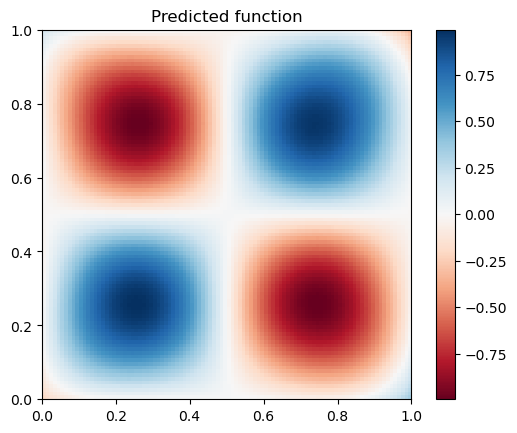

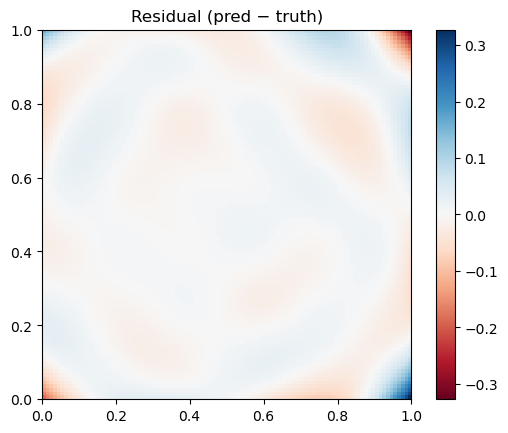

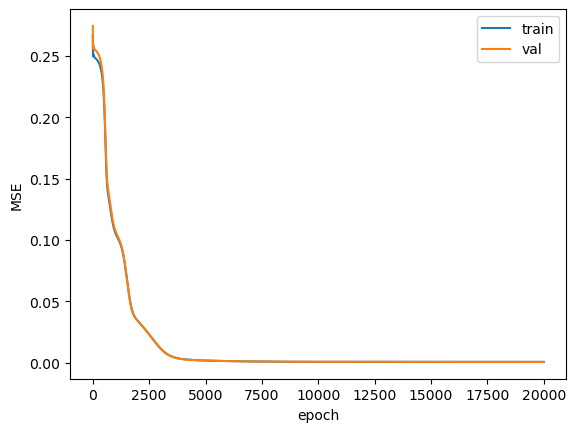

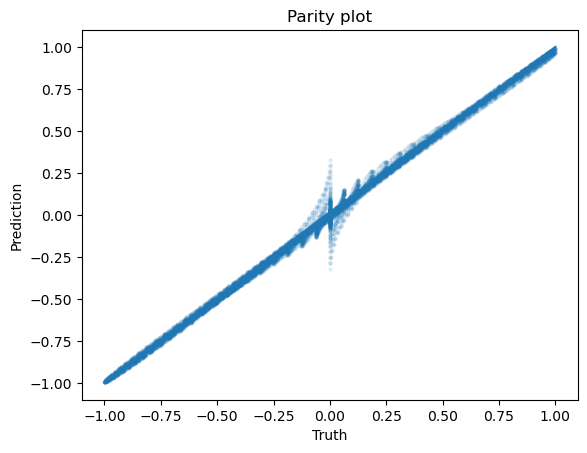

In [573]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 4000
X = torch.rand(N, 2, device=device)
y = torch.sin(2*math.pi*X[:,0:1]) * torch.sin(2*math.pi*X[:,1:2])
n_train = int(0.8*N)
indices = torch.randperm(N, device=device)
train_idx, val_idx = indices[:n_train], indices[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

nodes = 30
act = nn.Tanh()
model = nn.Sequential(
    nn.Linear(2, nodes), act,
    nn.Linear(nodes, nodes), act,
    nn.Linear(nodes, nodes), act,
    nn.Linear(nodes, 1)
).to(device)

loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  

# ----- training loop -----
epochs = 20000
train_hist, val_hist = [], []
best_val, best_epoch = float('inf'), -1

for epoch in range(epochs):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) == 9000:
        for g in optimizer.param_groups:
            g['lr'] = 0.001   
            pass

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, y_val)

    # record every epoch
    v = val_loss.item()
    train_hist.append(loss.item())
    val_hist.append(v)
    if v < best_val:
        best_val, best_epoch = v, epoch+1

    # print occasionally
    if (epoch+1) % 500 == 0:
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch+1} | lr={cur_lr:.5f} | train MSE={loss.item():.6f} | val MSE={v:.6f}")

# ----- grid for plots -----
p = torch.linspace(0, 1, 100, device=device)
xp, yp = torch.meshgrid(p, p, indexing="ij")
grid = torch.stack([xp.reshape(-1), yp.reshape(-1)], dim=1)

model.eval()
with torch.no_grad():
    Z_true = (torch.sin(2*math.pi*grid[:,0:1]) * torch.sin(2*math.pi*grid[:,1:2])).reshape(100,100)
    Z_pred = model(grid).reshape(100,100)

# ----- summary -----
print("\n=== Summary (deep) ===")
beta = optimizer.param_groups[0].get('momentum', 0.0)
print(f"optimizer=SGD, beta={beta:.2f}")
print(f"Best val MSE   : {best_val:.6f}")
print(f"Epoch of best  : {best_epoch}")
print(f"Final train MSE: {train_hist[-1]:.6f}")
print(f"Final val MSE  : {val_hist[-1]:.6f}")

# ----- plots -----
res = (Z_pred - Z_true).detach().cpu().numpy()
m = abs(res).max()
plt.figure(); plt.title("Predicted function")
plt.imshow(Z_pred.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="RdBu"); plt.colorbar()
plt.savefig("PredictedFunction.png", dpi=300, bbox_inches='tight')
#
plt.figure(); plt.title("Residual (pred − truth)")
plt.imshow(res, origin="lower", extent=[0,1,0,1], cmap="RdBu", vmin=-m, vmax=m); plt.colorbar()
plt.savefig("Residual.png", dpi=300, bbox_inches='tight')
plt.show()
#
plt.figure()
plt.plot(train_hist, label="train")
plt.plot(val_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend()
plt.savefig("MSEvsEpoch.png", dpi=300, bbox_inches='tight')
plt.show()
#
t = Z_true.detach().cpu().numpy().ravel()
p_ = Z_pred.detach().cpu().numpy().ravel()
m = max(abs(t).max(), abs(p_).max())
plt.figure(); plt.scatter(t, p_, s=5, alpha=0.1)
plt.plot([-m, m], [-m, m])
plt.xlabel("Truth"); plt.ylabel("Prediction"); plt.title("Parity plot"); 
plt.savefig("Parity.png", dpi=300, bbox_inches='tight')
plt.show()


# **Second Function**

The second function is defined as  

$$
f_{2}(x,y) =
\begin{cases}
1 & \text{if } x > y \\
0 & \text{if } x \leq y
\end{cases}
$$

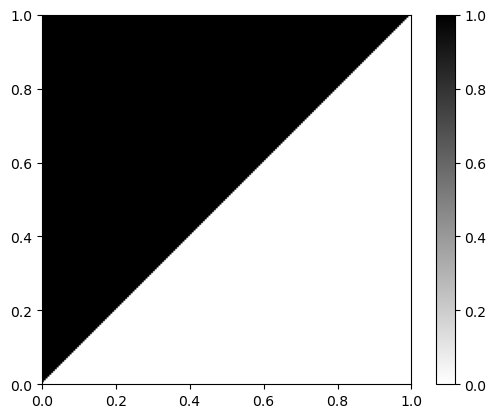

In [590]:
plt.figure()
plt.imshow(Z_true.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="gray_r"); plt.colorbar()
plt.savefig("F2-Groundturth.png", dpi=300, bbox_inches='tight')

**Shallow Network**

epoch 500 | lr=0.01000 | train BCE=0.1690, acc=98.78% | val BCE=0.1657, acc=98.75%
epoch 1000 | lr=0.01000 | train BCE=0.0939, acc=99.75% | val BCE=0.0931, acc=99.62%
epoch 1500 | lr=0.01000 | train BCE=0.0719, acc=99.78% | val BCE=0.0708, acc=99.75%
epoch 2000 | lr=0.01000 | train BCE=0.0605, acc=99.78% | val BCE=0.0589, acc=99.75%
epoch 2500 | lr=0.01000 | train BCE=0.0532, acc=99.81% | val BCE=0.0513, acc=99.75%
epoch 3000 | lr=0.01000 | train BCE=0.0480, acc=99.78% | val BCE=0.0459, acc=99.75%
epoch 3500 | lr=0.01000 | train BCE=0.0440, acc=99.78% | val BCE=0.0417, acc=99.75%
epoch 4000 | lr=0.01000 | train BCE=0.0409, acc=99.78% | val BCE=0.0385, acc=99.75%
epoch 4500 | lr=0.01000 | train BCE=0.0384, acc=99.78% | val BCE=0.0359, acc=99.75%
epoch 5000 | lr=0.01000 | train BCE=0.0363, acc=99.78% | val BCE=0.0337, acc=99.75%
epoch 5500 | lr=0.01000 | train BCE=0.0345, acc=99.78% | val BCE=0.0318, acc=99.75%
epoch 6000 | lr=0.01000 | train BCE=0.0329, acc=99.78% | val BCE=0.0302, acc=

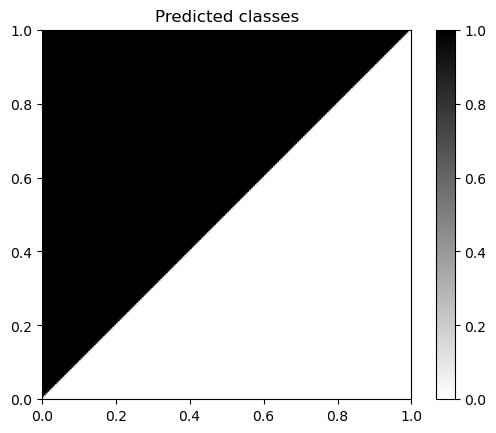

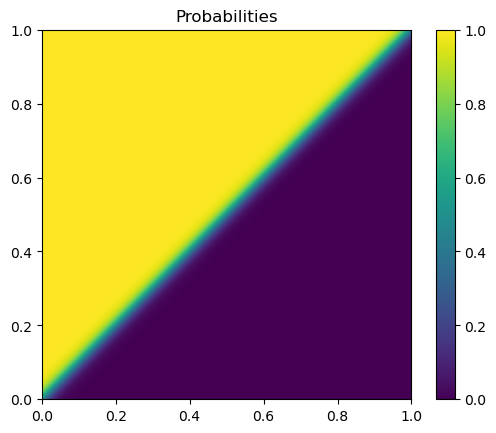

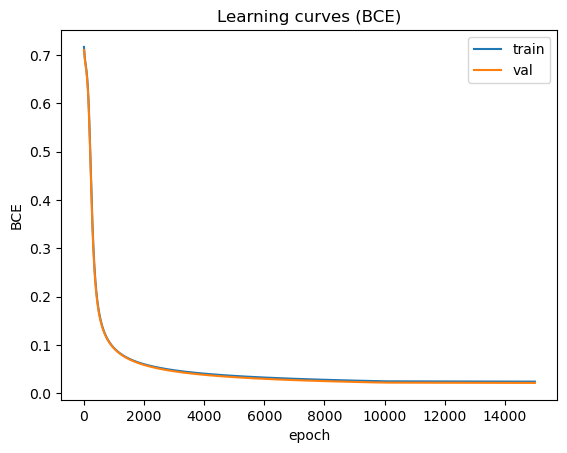

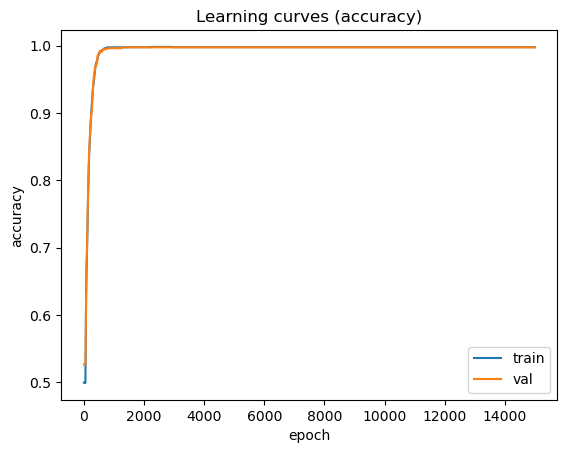

In [669]:
import os, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N = 4000
X = torch.rand(N, 2, device=device)
y = (X[:, 0:1] > X[:, 1:2]).float()

n_train = int(0.8 * N)
indices = torch.randperm(N, device=device)
train_idx, val_idx = indices[:n_train], indices[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

nodes = 10
model = nn.Sequential(nn.Linear(2, nodes),nn.ReLU(), nn.Linear(nodes, 1)).to(device)

loss_fn = nn.BCEWithLogitsLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.10, momentum=0.0)  
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  

epochs = 15000
train_bce, val_bce = [], []
train_acc, val_acc = [], []
best_val_acc, best_epoch = 0.0, -1
best_val_bce, best_bce_epoch = float('inf'), -1
for epoch in range(epochs):
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # late decay
    if (epoch + 1) == 10000:
        for g in optimizer.param_groups:
            g['lr'] = 0.001   
            pass

    # eval every epoch
    model.eval()
    with torch.no_grad():
        # train metrics
        probs_tr = torch.sigmoid(logits)
        preds_tr = (probs_tr >= 0.5).float()
        acc_tr = (preds_tr == y_train).float().mean().item()
        bce_tr = loss.item()

        # val metrics
        logits_val = model(X_val)
        bce_val = loss_fn(logits_val, y_val).item()
        probs_val = torch.sigmoid(logits_val)
        preds_val = (probs_val >= 0.5).float()
        acc_val = (preds_val == y_val).float().mean().item()

    train_bce.append(bce_tr); val_bce.append(bce_val)
    train_acc.append(acc_tr); val_acc.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc, best_epoch = acc_val, epoch + 1
    if bce_val < best_val_bce:
        best_val_bce, best_bce_epoch = bce_val, epoch+1
    if (epoch + 1) % 500 == 0:
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch+1} | lr={cur_lr:.5f} | "
              f"train BCE={bce_tr:.4f}, acc={acc_tr*100:.2f}% | "
              f"val BCE={bce_val:.4f}, acc={acc_val*100:.2f}%")

# ----- grid plots -----
p = torch.linspace(0, 1, 200, device=device)
xp, yp = torch.meshgrid(p, p, indexing="ij")
grid = torch.stack([xp.reshape(-1), yp.reshape(-1)], dim=1)

model.eval()
with torch.no_grad():
    Z_true  = (grid[:, 0:1] > grid[:, 1:2]).float().reshape(200, 200)
    Z_logit = model(grid)
    Z_prob  = torch.sigmoid(Z_logit).reshape(200, 200)
    Z_pred  = (Z_prob >= 0.5).float()
print("\n=== Summary (shallow, classification) ===")
beta = optimizer.param_groups[0].get('momentum', 0.0)
print(f"optimizer=SGD, beta={beta:.2f}")
print(f"Best val BCE : {best_val_bce:.6f} @ epoch {best_bce_epoch}")
print(f"Best val ACC : {best_val_acc*100:.2f}% @ epoch {best_epoch}")
print(f"Final ACC    : train={train_acc[-1]*100:.2f}% | val={val_acc[-1]*100:.2f}%")
print(f"Final BCE    : train={train_bce[-1]:.6f} | val={val_bce[-1]:.6f}")

plt.figure(); plt.title("Predicted classes")
plt.imshow(Z_pred.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="gray_r"); plt.colorbar()
plt.savefig("PredictedF2.png", dpi=300, bbox_inches='tight')
plt.figure(); plt.title("Probabilities")
plt.imshow(Z_prob.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="viridis"); plt.colorbar()
plt.savefig("ProbabilityF2.png", dpi=300, bbox_inches='tight')
plt.show()
plt.figure(); plt.title("Learning curves (BCE)")
plt.plot(train_bce, label="train"); plt.plot(val_bce, label="val")
plt.xlabel("epoch"); plt.ylabel("BCE"); plt.legend()
plt.savefig("BCEEPOCHF2.png", dpi=300, bbox_inches='tight')
plt.figure(); plt.title("Learning curves (accuracy)")
plt.plot(train_acc, label="train"); plt.plot(val_acc, label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
plt.savefig("ACCURACY.png", dpi=300, bbox_inches='tight')



**Deep Neural Network**

epoch 500 | lr=0.01000 | train BCE=0.5400, acc=90.44% | val BCE=0.5295, acc=90.13%
epoch 1000 | lr=0.01000 | train BCE=0.0315, acc=99.72% | val BCE=0.0287, acc=99.75%
epoch 1500 | lr=0.01000 | train BCE=0.0192, acc=99.78% | val BCE=0.0168, acc=99.75%

=== Summary (deep, classification) ===
optimizer=SGD, beta=0.90
Best val BCE : 0.016763 @ epoch 1500
Best val ACC : 99.87% @ epoch 617
Final ACC    : train=99.78% | val=99.75%
Final BCE    : train=0.019175 | val=0.016763


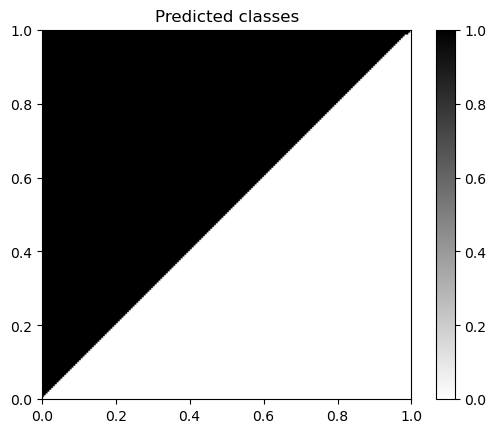

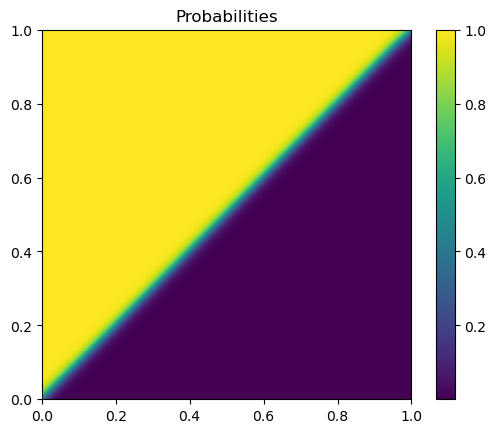

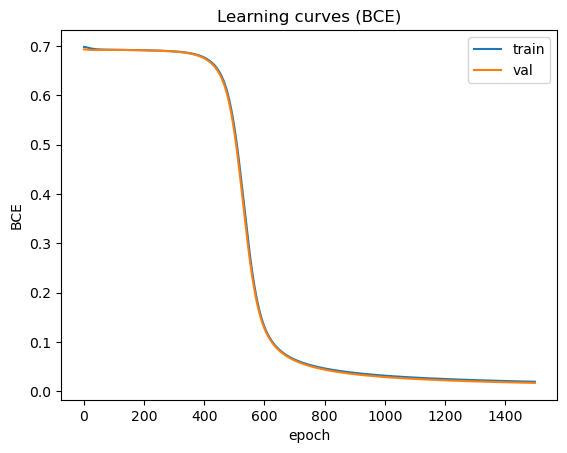

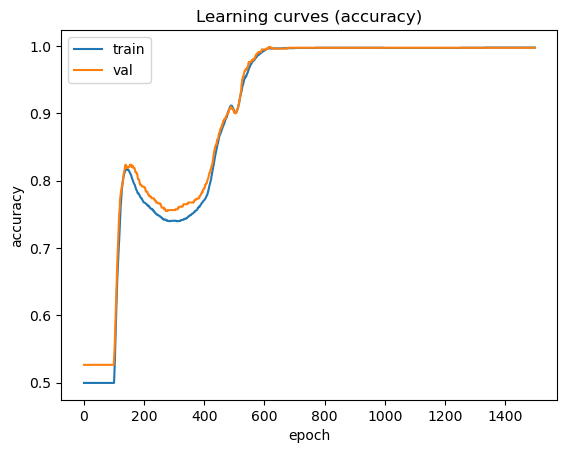

In [685]:
import os, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N = 4000
X = torch.rand(N, 2, device=device)
y = (X[:, 0:1] > X[:, 1:2]).float()

n_train = int(0.8 * N)
indices = torch.randperm(N, device=device)
train_idx, val_idx = indices[:n_train], indices[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

# ---- model: DEEP (replace your model block) ----
act = nn.ReLU()
nodes = 10
model = nn.Sequential(
    nn.Linear(2, nodes), act,
    nn.Linear(nodes, nodes), act,
    nn.Linear(nodes, nodes), act,
    nn.Linear(nodes, 1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.10, momentum=0.0)  
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  

epochs = 1500
train_bce, val_bce = [], []
train_acc, val_acc = [], []
best_val_acc, best_epoch = 0.0, -1
best_val_bce, best_bce_epoch = float('inf'), -1
for epoch in range(epochs):
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # late decay
    if (epoch + 1) == 1000:
        for g in optimizer.param_groups:
            g['lr'] = 0.01   
            pass

    # eval every epoch
    model.eval()
    with torch.no_grad():
        # train metrics
        probs_tr = torch.sigmoid(logits)
        preds_tr = (probs_tr >= 0.5).float()
        acc_tr = (preds_tr == y_train).float().mean().item()
        bce_tr = loss.item()

        # val metrics
        logits_val = model(X_val)
        bce_val = loss_fn(logits_val, y_val).item()
        probs_val = torch.sigmoid(logits_val)
        preds_val = (probs_val >= 0.5).float()
        acc_val = (preds_val == y_val).float().mean().item()

    train_bce.append(bce_tr); val_bce.append(bce_val)
    train_acc.append(acc_tr); val_acc.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc, best_epoch = acc_val, epoch + 1
    if bce_val < best_val_bce:
        best_val_bce, best_bce_epoch = bce_val, epoch+1
    if (epoch + 1) % 500 == 0:
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch+1} | lr={cur_lr:.5f} | "
              f"train BCE={bce_tr:.4f}, acc={acc_tr*100:.2f}% | "
              f"val BCE={bce_val:.4f}, acc={acc_val*100:.2f}%")

# ----- grid plots -----
p = torch.linspace(0, 1, 200, device=device)
xp, yp = torch.meshgrid(p, p, indexing="ij")
grid = torch.stack([xp.reshape(-1), yp.reshape(-1)], dim=1)

model.eval()
with torch.no_grad():
    Z_true  = (grid[:, 0:1] > grid[:, 1:2]).float().reshape(200, 200)
    Z_logit = model(grid)
    Z_prob  = torch.sigmoid(Z_logit).reshape(200, 200)
    Z_pred  = (Z_prob >= 0.5).float()
print("\n=== Summary (deep, classification) ===")
beta = optimizer.param_groups[0].get('momentum', 0.0)
print(f"optimizer=SGD, beta={beta:.2f}")
print(f"Best val BCE : {best_val_bce:.6f} @ epoch {best_bce_epoch}")
print(f"Best val ACC : {best_val_acc*100:.2f}% @ epoch {best_epoch}")
print(f"Final ACC    : train={train_acc[-1]*100:.2f}% | val={val_acc[-1]*100:.2f}%")
print(f"Final BCE    : train={train_bce[-1]:.6f} | val={val_bce[-1]:.6f}")

plt.figure(); plt.title("Predicted classes")
plt.imshow(Z_pred.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="gray_r"); plt.colorbar()
plt.savefig("PredictedF2.png", dpi=300, bbox_inches='tight')
plt.figure(); plt.title("Probabilities")
plt.imshow(Z_prob.detach().cpu().numpy(), origin="lower", extent=[0,1,0,1], cmap="viridis"); plt.colorbar()
plt.savefig("ProbabilityF2.png", dpi=300, bbox_inches='tight')
plt.show()
plt.figure(); plt.title("Learning curves (BCE)")
plt.plot(train_bce, label="train"); plt.plot(val_bce, label="val")
plt.xlabel("epoch"); plt.ylabel("BCE"); plt.legend()
plt.savefig("BCEEPOCHF2.png", dpi=300, bbox_inches='tight')
plt.figure(); plt.title("Learning curves (accuracy)")
plt.plot(train_acc, label="train"); plt.plot(val_acc, label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
plt.savefig("ACCURACY.png", dpi=300, bbox_inches='tight')

